**Market Basket Analysis**

Adaptado para um dataframe do *Kaggle* para garantir o sigilo do cliente.

Esse codigo foi executado em 2023 para 16 clientes nacionais e multinacionais.

In [7]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

from mlxtend.frequent_patterns import association_rules, apriori # for mining frequent itemsets and association rule

import warnings
warnings.filterwarnings("ignore")

In [9]:
from faker import Faker

Pré-processamento dos dados

In [13]:
# load data and get overview
df = pd.read_csv("sample.csv")
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [17]:
print('The total number of unique transactions is ', df['Transaction'].nunique())

The total number of unique transactions is  9465


In [18]:
print('The total number of selling items is ', df['Item'].nunique())

The total number of selling items is  94


In [19]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,2016-10-30 09:58:00,morning,weekend
1,2,Scandinavian,2016-10-30 10:05:00,morning,weekend
2,2,Scandinavian,2016-10-30 10:05:00,morning,weekend
3,3,Hot chocolate,2016-10-30 10:07:00,morning,weekend
4,3,Jam,2016-10-30 10:07:00,morning,weekend


In [20]:
df['date'] = df['date_time'].dt.date
df['month'] = df['date_time'].dt.strftime('%Y-%m')
df['weekday'] = df['date_time'].dt.strftime('%A')
df.drop('date_time', axis = 1, inplace = True)
df.head()

,Transaction,Item,period_day,weekday_weekend,date,hour,month,weekday
0,1,Bread,morning,weekend,2016-10-30,9,2016-10,Sunday
1,2,Scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
2,2,Scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
3,3,Hot chocolate,morning,weekend,2016-10-30,10,2016-10,Sunday
4,3,Jam,morning,weekend,2016-10-30,10,2016-10,Sunday


In [22]:
# change the item name to lowercase and remove any spaces
df['Item'] = df['Item'].str.strip()
df['Item'] = df['Item'].str.lower()
df.head()

,Transaction,Item,period_day,weekday_weekend,date,hour,month,weekday
0,1,bread,morning,weekend,2016-10-30,9,2016-10,Sunday
1,2,scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
2,2,scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
3,3,hot chocolate,morning,weekend,2016-10-30,10,2016-10,Sunday
4,3,jam,morning,weekend,2016-10-30,10,2016-10,Sunday


Data Viz

In [23]:
# count the number of items sold in descending order, take Top 20 best selling items
top_items = pd.DataFrame(df['Item'].value_counts(dropna=True, sort=True)).reset_index()
top_items.columns = ['item', 'count']
top_items['percentage'] = top_items['count'].apply(lambda x: x/top_items['count'].sum())
top_items = top_items.head(20)
top_items.head()

,item,count,percentage
0,coffee,5471,0.266787
1,bread,3325,0.162140
2,tea,1435,0.069976
3,cake,1025,0.049983
4,pastry,856,0.041742


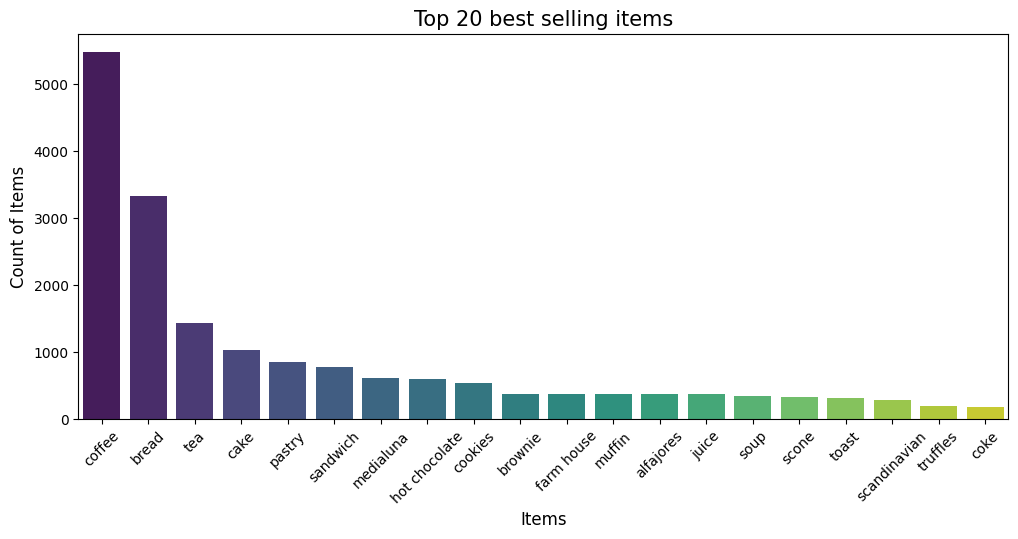

In [24]:
# create bar plot showing Top 20 best selling items
plt.figure(figsize=(12,5))
sns.barplot(x = 'item', y = 'count', data = top_items, palette = 'viridis')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 12)
plt.title('Top 20 best selling items', size = 15)
plt.show()

In [30]:
# 1. create summary table of number of transactions by their number of items
# 2. count the number of items of each transaction
items_num = df.groupby('Transaction', as_index=False)['Item'].count()
# pivot table to display the distribution of transactions by the number of items
items_num = items_num.pivot_table(index='Item', values='Transaction', aggfunc='count')
# calculate percentage
items_num['percentage'] = items_num['Transaction'].apply(lambda x: x/items_num['Transaction'].sum())
items_num

,Transaction,percentage
Item,,
1,3631,0.383624
2,2908,0.307237
3,1528,0.161437
4,850,0.089805
5,341,0.036027
6,135,0.014263
7,38,0.004015
8,21,0.002219
9,7,0.000740


In [33]:
# count the quantity of items sold by month and year
qty_month = df.groupby('month', as_index=False)['Transaction'].count()
qty_month.head()

,month,Transaction
0,2016-01,233
1,2016-02,268
2,2016-03,380
3,2016-04,308
4,2016-05,392


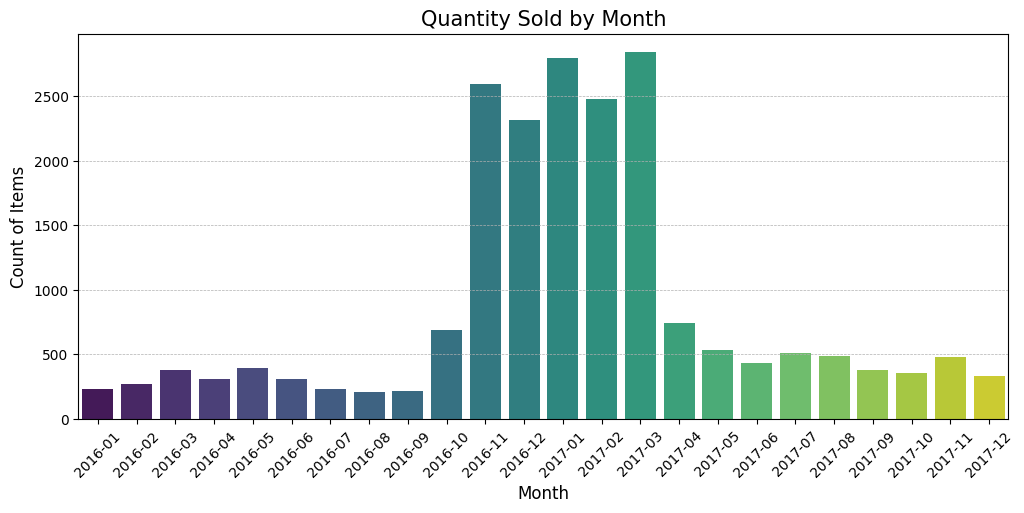

In [34]:
# create bar plot showing the number of items sold by month
plt.figure(figsize=(12,5))
sns.barplot(x = 'month', y = 'Transaction', data = qty_month, palette = 'viridis')
plt.xlabel('Month', size = 12)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 12)
plt.title('Quantity Sold by Month', size = 15)
plt.grid(axis = 'y', ls='--', lw='0.5')
plt.show()

In [35]:
# count the number of transactions by days of week, reorder by names of the days
qty_wd = df.groupby('weekday', as_index=False)['Transaction'].count()
qty_wd['wdkey'] = [4,0,5,6,3,1,2]
qty_wd.sort_values("wdkey",inplace=True)
qty_wd

,weekday,Transaction,wdkey
1,Monday,3035,0
5,Tuesday,2645,1
6,Wednesday,2288,2
4,Thursday,2601,3
0,Friday,3266,4
2,Saturday,3554,5
3,Sunday,3118,6


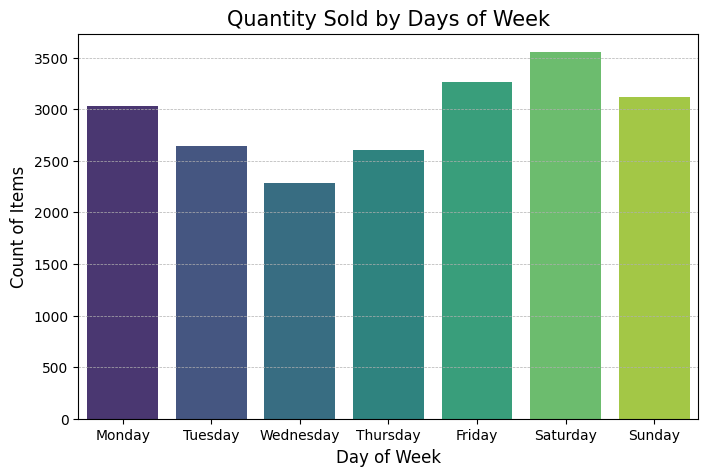

In [36]:
# create bar plot showing the number of items sold by days of week
plt.figure(figsize=(8,5))
sns.barplot(x = 'weekday', y = 'Transaction', data = qty_wd, palette = 'viridis')
plt.xlabel('Day of Week', size = 12)
plt.ylabel('Count of Items', size = 12)
plt.title('Quantity Sold by Days of Week', size = 15)
plt.grid(axis = 'y', ls='--', lw='0.5')
plt.show()

**Aplicando o algoritmo Apriori para o Market Basket Analysis**

*A função apriori espera dados de entrada em um DataFrame pandas codificado one-hot, portanto, precisamos transformar o dataframe acima na representação de variáveis ​​​​categóricas como vetores binários.*

In [37]:
# select only required variables for modelling
transactions = df.groupby(['Transaction', 'Item'])['Item'].count().reset_index(name ='Count')
transactions.head()

,Transaction,Item,Count
0,1,bread,1
1,2,scandinavian,2
2,3,cookies,1
3,3,hot chocolate,1
4,3,jam,1


In [38]:
# first create a mxn matrice where m=transaction and n=items
# each row represents whether the items was in a specific transaction or not (>=1 returns True (1), 0 returns 0)
my_basket = transactions.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='any').fillna(0)

my_basket.head()

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Suporte mínimo é a frequência mínima ou limite de ocorrência que um conjunto de itens deve atender para ser considerado frequente.

In [39]:
# create frequent items df with itemsets and support columns by using `apriori` function
frequent_items = apriori(my_basket, min_support = 0.01, use_colnames = True)
frequent_items

,support,itemsets
0,0.036344,(alfajores)
1,0.016059,(baguette)
2,0.327205,(bread)
3,0.040042,(brownie)
4,0.103856,(cake)
...,...,...
56,0.023666,"(toast, coffee)"
57,0.014369,"(tea, sandwich)"
58,0.010037,"(cake, bread, coffee)"
59,0.011199,"(bread, coffee, pastry)"


Só porque um item ou conjunto de itens é comum não significa que exista uma forte associação entre eles. Por exemplo, o item “café” pode ter um valor de apoio elevado, mas isso não significa que exista uma forte associação entre o café e qualquer outro item específico. Portanto, devemos considerar a métrica **lift** ao avaliar as associações entre os itens.

O aumento indica quantas vezes mais A e B realmente aparecem na mesma ordem, em comparação com se não houvesse relação entre eles. Ou seja, leva em consideração o apoio de cada item para medir a força da associação entre eles. Um valor de aumento de 1 significa que não há associação entre os dois itens. Um valor de elevação superior a 1 significa que os dois itens estão positivamente associados, o que significa que a presença de um item aumenta a probabilidade da presença do outro item.

Este projeto definirá o limite mínimo para a métrica **lift** em 1,2 para retornar as regras de associação que ocorrem pelo menos 20% mais frequentemente do que esperaríamos se fossem aleatórias.

In [40]:
# create the rules from frequent itemset generated above with min lift = 1.2
rules = association_rules(frequent_items, metric = "lift", min_threshold = 1.2)
rules.sort_values('confidence', ascending = False, inplace = True)
rules.reset_index(drop=True, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(toast),(coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
1,(spanish brunch),(coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
2,(cake),(tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865,0.420538
3,"(tea, coffee)",(cake),0.049868,0.103856,0.010037,0.201271,1.937977,0.004858,1.121962,0.509401
4,(sandwich),(tea),0.071844,0.142631,0.014369,0.200000,1.402222,0.004122,1.071712,0.309050
5,(hot chocolate),(cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125,0.498236
6,"(cake, coffee)",(tea),0.054728,0.142631,0.010037,0.183398,1.285822,0.002231,1.049923,0.235157
7,(tea),(cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372,0.439556
8,(pastry),"(bread, coffee)",0.086107,0.090016,0.011199,0.130061,1.444872,0.003448,1.046033,0.336907
9,"(bread, coffee)",(pastry),0.090016,0.086107,0.011199,0.124413,1.444872,0.003448,1.043749,0.338354


Barras Coordenadas

Lift Heatmap

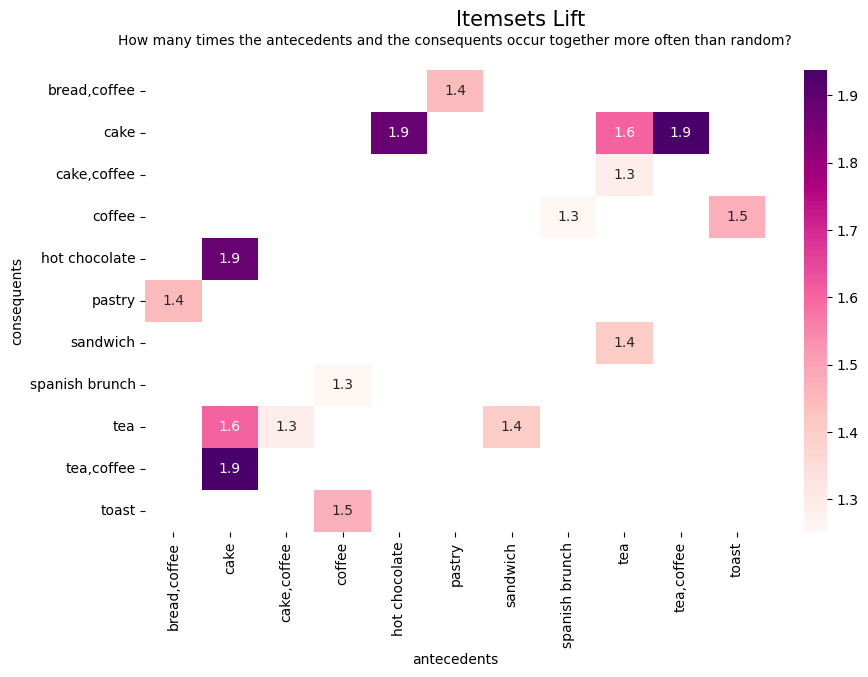

In [42]:
# convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# transform antecedent, consequent, and support columns into matrix
support_table_lift = rules.pivot(index='consequents', columns='antecedents', values='lift')

# generate a heatmap with annotations 
plt.figure(figsize=(10,6))
sns.heatmap(support_table_lift, annot = True, cbar = True, cmap="RdPu")
plt.suptitle('Itemsets Lift', size = 15)
plt.title('How many times the antecedents and the consequents occur together more often than random?\n', size=10)
plt.show()

Confidence Heatmap

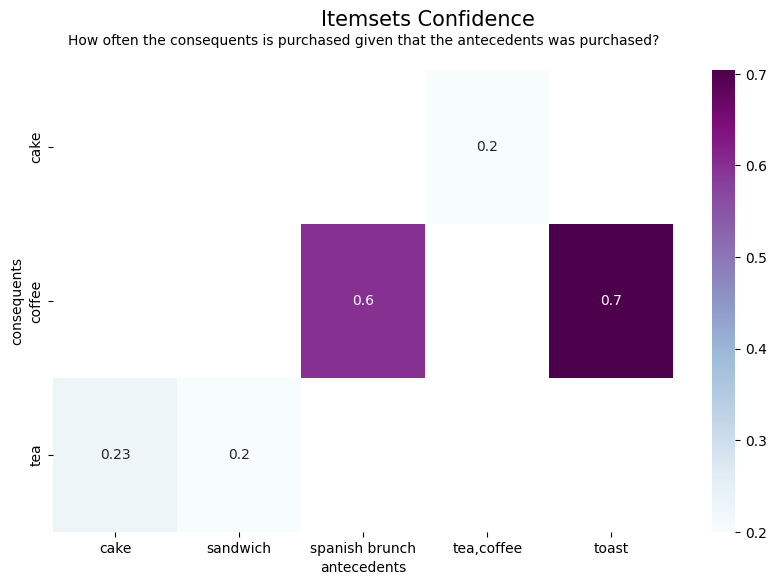

In [43]:
# transform antecedent, consequent, and support columns into matrix
rules_confidence = rules[rules['confidence']>=0.2] # select min lift=1.2
support_table_conf = rules_confidence.pivot(index='consequents', columns='antecedents', values='confidence')

# generate a heatmap with annotations
plt.figure(figsize=(10,6))
sns.heatmap(support_table_conf, annot = True, cbar = True, cmap="BuPu")
plt.suptitle('Itemsets Confidence', size = 15)
plt.title('How often the consequents is purchased given that the antecedents was purchased?\n', size = 10)
plt.show()